In [1]:
# Libraries used
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from numpy.random import seed
seed(244)

# Load Data

In [2]:
path = "./data-144-kaggle-competition/"
train = pd.read_csv(path + 'train.csv', header=0)
test = pd.read_csv(path + 'test.csv', header=0)

train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

df = pd.concat([train, test], axis=0, sort=False)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Dictionary

*   **Survived** : Survival, 0 = No, 1 = Yes
*   **Pclass** : Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
*   **Sex** : Sex
*   **Age**: Age in years
*   **SibSp**: Number of siblings / spouses aboard the Titanic
*   **Parch**: Number of parents / children aboard the Titanic
*   **Ticket**: Ticket number
*   **Fare**: Passenger fare
*   **Cabin**: Cabin number
*   **Embarked**: Part of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

## Variable Notes

*   Pclass: A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

*   Age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

*   SibSp: The number of siblings/spouses

*   Parch: The number of parents/children
*   Some children travelled only with a nanny, therefore parch=0 for them.

# 1. EDA

In [3]:
ordinal = ['Pclass']
df[ordinal].nunique()

Pclass    3
dtype: int64

In [4]:
categorical = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
df[categorical].nunique()

Name        1307
Sex            2
Ticket       929
Cabin        186
Embarked       3
dtype: int64

In [5]:
print('--- unique values in features ---')
print('Pclass:\t{}'.format(df.Pclass.unique()).expandtabs(12))
print('Sex:\t{}'.format(df.Sex.unique()).expandtabs(12))
print('Embarked:\t{}'.format(df.Embarked.unique()).expandtabs(12))

--- unique values in features ---
Pclass:     [3 1 2]
Sex:        ['male' 'female']
Embarked:   ['S' 'C' 'Q' nan]


In [6]:
numerical = ['Age', 'SibSp', 'Parch', 'Fare']
df[numerical].describe()

,Age,SibSp,Parch,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.498854,0.385027,33.295479
std,14.413493,1.041658,0.865560,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


## 1.1 Features Distribution and Missing Values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [8]:
len(df) - len(test)

891

We can see that there are missing values in columns `Survived`, `Age`, `Fare`, `Cabin` and `Embarked`. The missing values in `Survived` is because we don't have the labels for the test set. For others missing values, we would like to do some more EDA and find a way to fill/impute or deal with thoses values.

In [9]:
# find missing values' counts and percentages
df.isna().sum().to_frame('na_counts').merge((df.isna().sum() / len(df) * 100).round(2).to_frame('na_percentage'), left_index=True, right_index=True)

,na_counts,na_percentage
Survived,418,31.93
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,263,20.09
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.08
Cabin,1014,77.46


For the sake of exploration, we'd like to transform `Sex` column into 1's and 0's.

In [10]:
df['Sex_mapped'] = df['Sex'].map({'female':0, 'male':1})

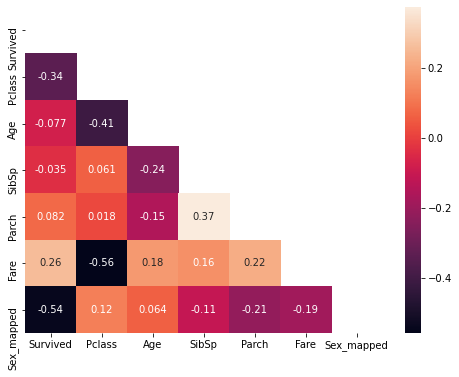

In [11]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True);

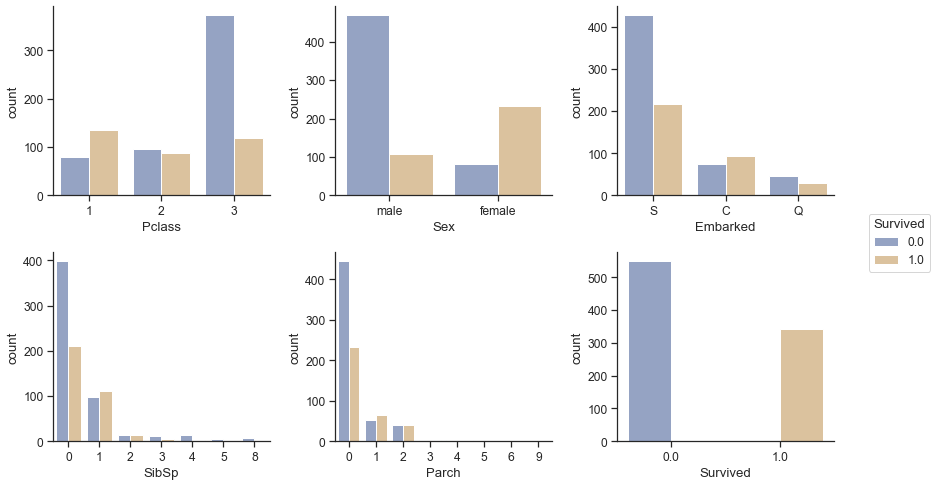

In [12]:
columns = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'Survived']

palette = sns.color_palette('Set2')[2:7:4]
sns.set_theme(style='ticks', font_scale=1.1, palette=palette)

fig = plt.figure(figsize=(14, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(6):
  plt.subplot(2, 3, i+1)
  ax = sns.countplot(data=df, x=columns[i], hue='Survived')
  ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='Survived')
sns.despine();

### `Age`: (263 missing == 20.09%)

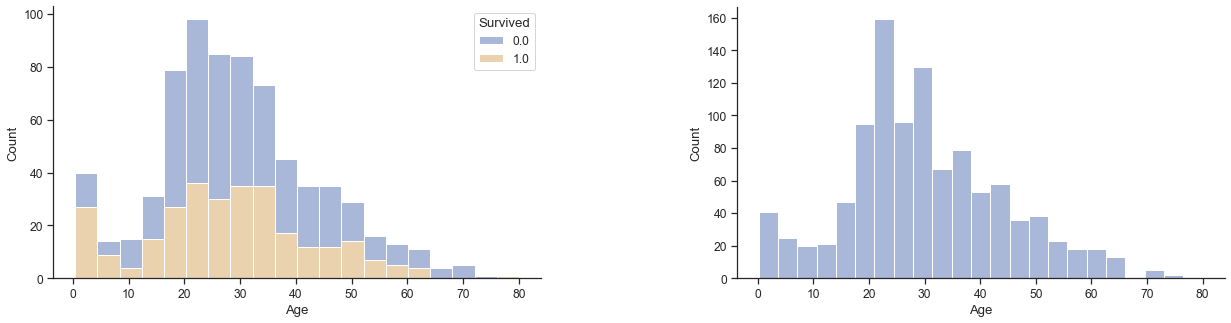

In [13]:
plt.figure(figsize=(21,5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,2,1)
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', palette=palette)
plt.subplot(1,2,2)
sns.histplot(data=df, x='Age', palette=palette)
sns.despine()

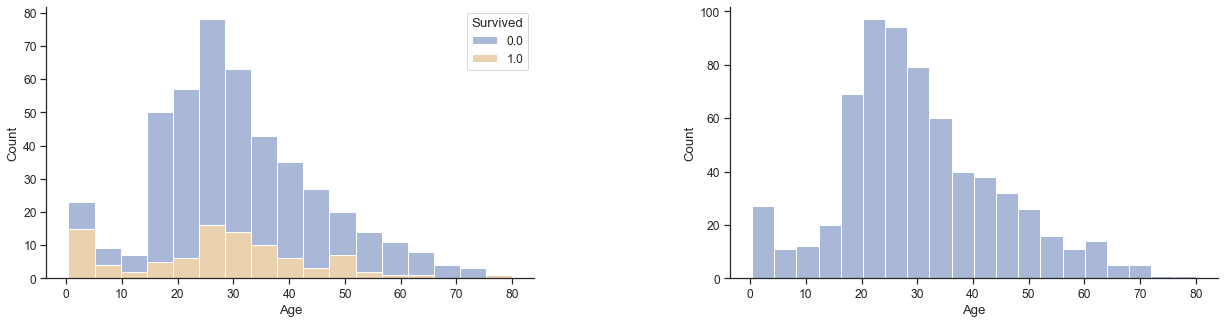

In [14]:
plt.figure(figsize=(21,5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,2,1)
sns.histplot(data=df[df.Sex == 'male'], x='Age', hue='Survived', multiple='stack', palette=palette)
plt.subplot(1,2,2)
sns.histplot(data=df[df.Sex == 'male'], x='Age', palette=palette)
sns.despine()

In [15]:
df.corr()['Age'].reindex(df.corr()['Age'].abs().sort_values(ascending=False).index)

Age           1.000000
Pclass       -0.408106
SibSp        -0.243699
Fare          0.178740
Parch        -0.150917
Survived     -0.077221
Sex_mapped    0.063645
Name: Age, dtype: float64

In [16]:
df.groupby('Pclass').Age.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,284.0,39.159930,14.548028,0.92,28.0,39.0,50.0,80.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.0,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.0,74.0


As seen from the heatmap before, we may want to use median/mean of age in each `Pclass` to fill in missing values for `Age` since **`Pclass` has the highest correlation with `Age`**.

### Fare: (1 missing == 0.08%)

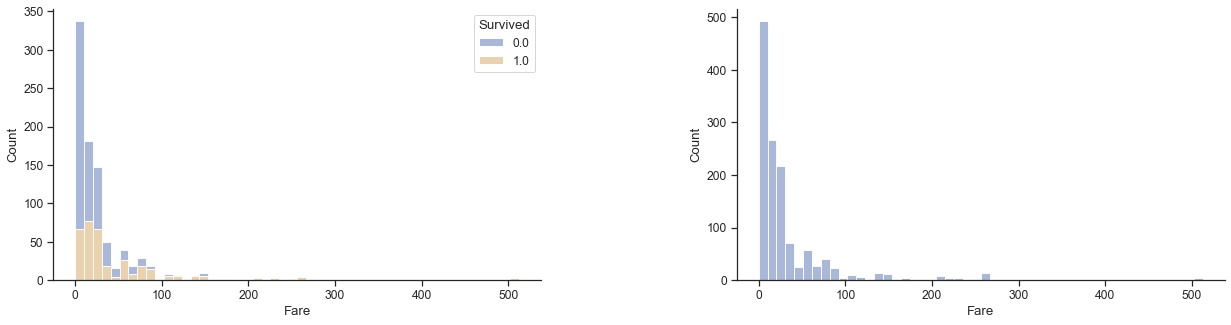

In [17]:
plt.figure(figsize=(21,5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,2,1)
sns.histplot(data=df, x='Fare', hue='Survived', bins=50, multiple='stack', palette=palette)
plt.subplot(1,2,2)
sns.histplot(data=df, x='Fare', bins=50, palette=palette)
sns.despine()

In [18]:
df.corr()['Fare'].reindex(df.corr()['Fare'].abs().sort_values(ascending=False).index)

Fare          1.000000
Pclass       -0.558629
Survived      0.257307
Parch         0.221539
Sex_mapped   -0.185523
Age           0.178740
SibSp         0.160238
Name: Fare, dtype: float64

In [19]:
df.groupby('Pclass').Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,87.508992,80.447178,0.0,30.6958,60.0000,107.6625,512.3292
2,277.0,21.179196,13.607122,0.0,13.0000,15.0458,26.0000,73.5000
3,708.0,13.302889,11.494358,0.0,7.7500,8.0500,15.2458,69.5500


Similar to `Age`, we may want to use median/mean of fare in each `Pclass` to fill in missing values for `Fare` since **`Pclass` has the highest correlation with `Fare`**.

### `Cabin`: (1014 missing == 77.46%)

In [20]:
df.Cabin.describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object

Since over 75% of this feature is missing, we decide to drop it.

### `Embarked`: (2 missing == 0.15%)

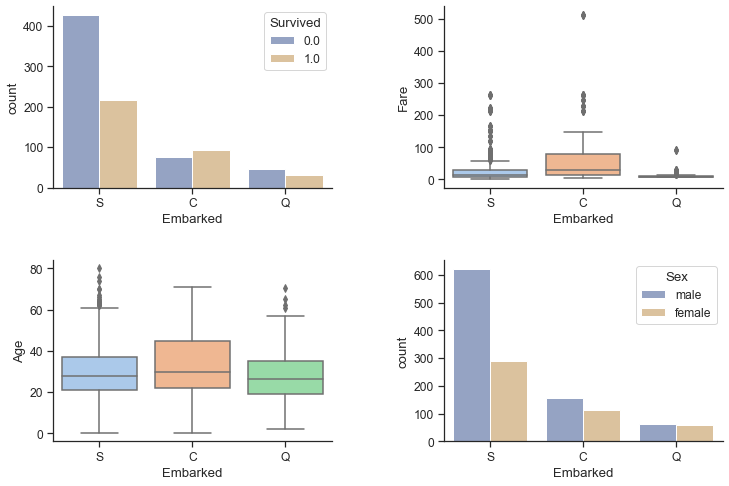

In [21]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2,2,1)
sns.countplot(data=df, x='Embarked', hue='Survived', palette=palette)
plt.subplot(2,2,2)
sns.boxplot(data=df, x='Embarked', y='Fare', palette=sns.color_palette('pastel'))
plt.subplot(2,2,3)
sns.boxplot(data=df, x='Embarked', y='Age', palette=sns.color_palette('pastel'))
plt.subplot(2,2,4)
sns.countplot(data=df, x='Embarked', hue='Sex', palette=palette)
sns.despine()

`Embarked` doesn't seem to have high correlation with other features, so we may want to drop the two samples or fill in the missing values with the mode, which is 'S'.

In [22]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_mapped
PassengerId,,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0


The two samples where `Embarked` is NA are both positive samples. Considering that we are dealing with an unbalanced dataset, we do not want to drop these two positive samples, and therefore we will fill in the missing values with the mode.

### `Name` and `Ticket` (categorical variables with high cardinality): 

In [23]:
print('number of unique Name is', df.Name.nunique())
print('number of unique Ticket is', df.Ticket.nunique())

number of unique Name is 1307
number of unique Ticket is 929


In [24]:
print('number of unique last name is', df.Name.str.split(',').str.get(0).nunique())

number of unique last name is 875


In [25]:
df.Ticket.value_counts()

CA. 2343        11
1601             8
CA 2144          8
347082           7
S.O.C. 14879     7
                ..
335097           1
370373           1
PC 17318         1
237798           1
250648           1
Name: Ticket, Length: 929, dtype: int64

In [26]:
df.groupby('Ticket').size().value_counts()

1     713
2     132
3      49
4      16
5       7
7       5
6       4
8       2
11      1
dtype: int64

In [27]:
# find Ticket with >= 8 entries
df[df.groupby('Ticket').Name.transform(len) >= 8].sort_values('Ticket')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_mapped
PassengerId,,,,,,,,,,,,
75,1.0,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,1
170,0.0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1
931,NaN,3,"Hee, Mr. Ling",male,NaN,0,0,1601,56.4958,NaN,S,1
839,1.0,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,1
827,0.0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1
693,1.0,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1
510,1.0,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1
644,1.0,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,1
60,0.0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,1


It seems that most people with the same `Ticket` number has the same last name, and seeing from `SibSp` and `Parch`, we know that these people are a family. **A good feature to extract can be related to family.**

## 1.2 More Insights on `Sex` Feature

Since our previous submission did not beat baseline(which was predict 1 for females and 0 for males), we would like to do some more EDA on the `Sex` column, which was the decisive feature for the baseline model.

In [28]:
fem = df[df.Sex == 'female']
ma = df[df.Sex == 'male']

# adding a FamilySize feature
fem['FamilySize'] = fem.Parch + fem.SibSp + 1
ma['FamilySize'] = ma.Parch + ma.SibSp + 1

<ipython-input-28-e8820e90b326>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fem['FamilySize'] = fem.Parch + fem.SibSp + 1
<ipython-input-28-e8820e90b326>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma['FamilySize'] = ma.Parch + ma.SibSp + 1


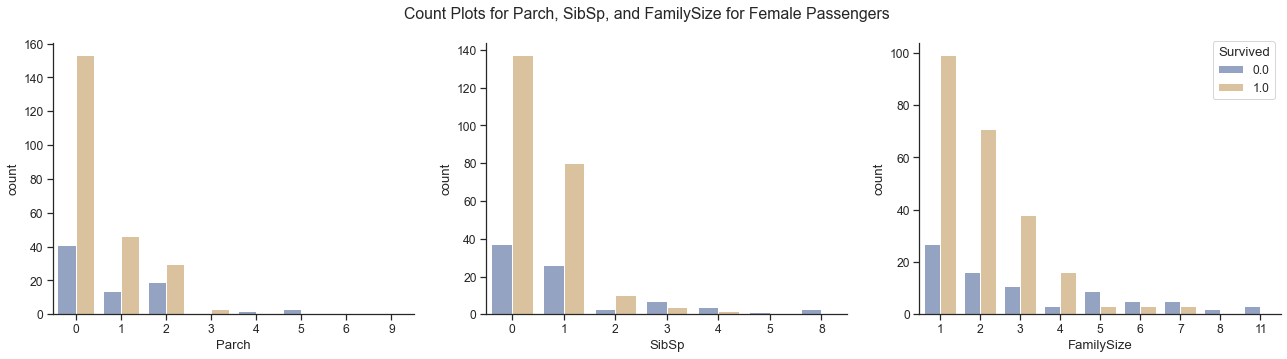

In [29]:
columns = ['Parch', 'SibSp', 'FamilySize']
fig = plt.figure(figsize=(22, 5))
plt.subplots_adjust(wspace=0.2)
palette = sns.color_palette('Set2')[2:7:4]

for i in range(3):
  plt.subplot(1, 3, i+1)
  ax = sns.countplot(data=fem, x=columns[i], hue='Survived', palette=palette)
  ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.9), title='Survived')
fig.suptitle('Count Plots for Parch, SibSp, and FamilySize for Female Passengers')
sns.despine();

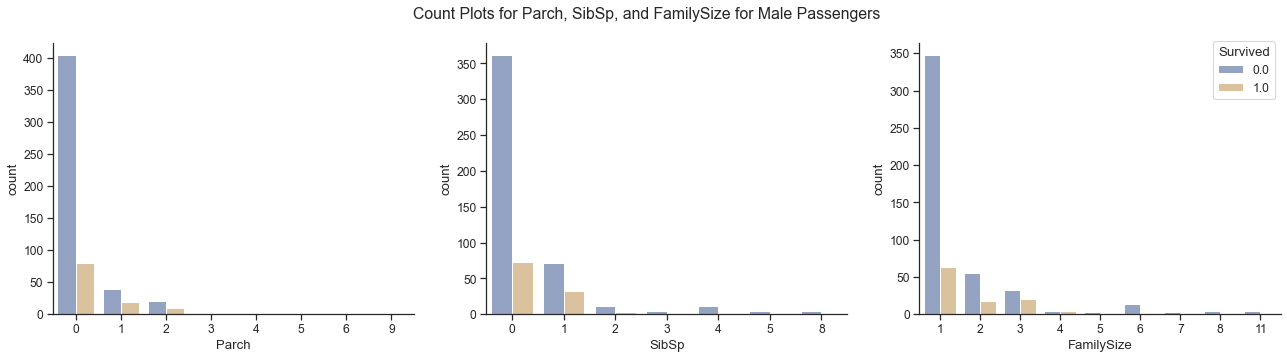

In [30]:
fig = plt.figure(figsize=(22, 5))
plt.subplots_adjust(wspace=0.2)
palette = sns.color_palette('Set2')[2:7:4]

for i in range(3):
  plt.subplot(1, 3, i+1)
  ax = sns.countplot(data=ma, x=columns[i], hue='Survived', palette=palette)
  ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.9), title='Survived')
fig.suptitle('Count Plots for Parch, SibSp, and FamilySize for Male Passengers')
sns.despine();

When you focus on the left part of each plot, there are way more survived female passengers when number of companies on board is small, but when number of companies on board increased, non-survived passengers starts to outnumber survived passengers. But for male passengers, non-survived passengers has consistently outnumbered survived passengers.


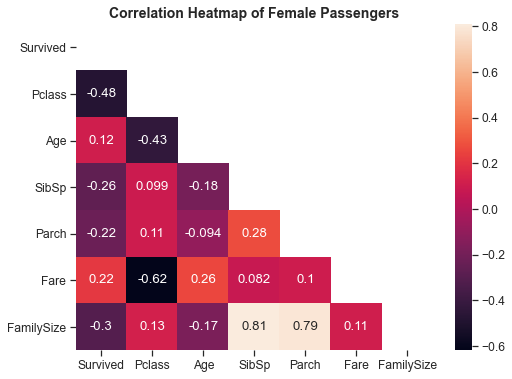

In [31]:
corr = fem.drop(columns='Sex_mapped').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Correlation Heatmap of Female Passengers', fontdict = {'fontsize' : 14, 'fontweight':'heavy'});

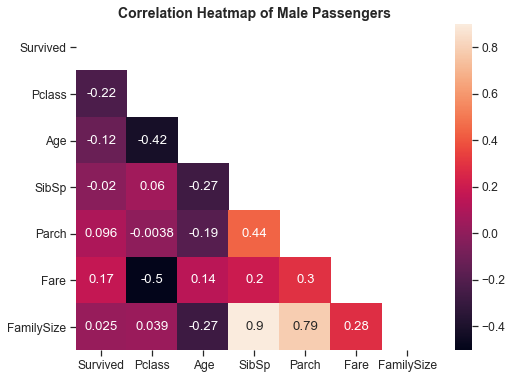

In [32]:
corr = ma.drop(columns='Sex_mapped').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True)
plt.title('Correlation Heatmap of Male Passengers', fontdict = {'fontsize' : 14, 'fontweight':'heavy'});

We can see that while `Survived` is highly correlated with `FamilySize`, `SibSp` and `Parch` for women, it is not the same case as with men!! Therefore, we might want to score females based on their `Parch` feature.

# Preprocessing

## Missing Values

In [33]:
data = pd.concat([train, test], axis=0, sort=False)

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
# binary sex
data['Sex'] = data.Sex.map({'female':0,'male':1})

In [35]:
# fill age with Pclass-Sex mean 
data["Age"].fillna(data.groupby('Pclass')['Age'].transform('mean'), inplace=True)

In [36]:
# fill Fare with Pclass-Sex mean 
data["Fare"].fillna(data.groupby('Pclass')['Fare'].transform('mean'), inplace=True)

In [37]:
# drop unused infos
data = data.drop(['Cabin','Embarked','Name'], axis = 1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
PassengerId,,,,,,,,
1,0.0,3,1,22.0,1,0,A/5 21171,7.2500
2,1.0,1,0,38.0,1,0,PC 17599,71.2833
3,1.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250
4,1.0,1,0,35.0,1,0,113803,53.1000
5,0.0,3,1,35.0,0,0,373450,8.0500


We decided to drop `Embarked` column because kaggle submission shows that without `Embarked` the accuracy was much higher.

## Feature Engineering

In [38]:
# 5 level encoding
le = LabelEncoder()
data['Fare'] = le.fit_transform(pd.cut(data['Fare'],5)) 
data['Age'] = le.fit_transform(pd.cut(data['Age'], 5)) 

In [39]:
data['FamilySize'] = data['SibSp']+ data['Parch'] + 1

### New Ordinal Feature: ComScore (score female passengers based on number of companies on board)

In [40]:
# female Parch engineering -> new feature: company score
data['ComScore'] = 3                                                                             # Male
data.loc[(data['Parch'] == 0)  & (data['Sex'] == 0), 'ComScore'] = 0                             # Small Family 
data.loc[(data['Parch'] == 1) & (data['FamilySize'] == 2)& (data['Sex'] == 0), 'ComScore'] = -1  # Parent Child Family
data.loc[(data['Parch'] == 1) & (data['FamilySize'] > 2) & (data['Sex'] == 0), 'ComScore'] = 1   # PC with siblings
data.loc[(data['Parch']  >= 2) & (data['Sex'] == 0), 'ComScore'] = 2                             # Large Family 

In [41]:
data.groupby('ComScore').size()

ComScore
-1     33
 0    293
 1     55
 2     85
 3    843
dtype: int64

In [42]:
survival_rate = data[:891].groupby('ComScore').apply(lambda x: '{}%'.format(round((x.Survived == 1).sum() / len(x) * 100, 2))).sort_index(ascending=False).values

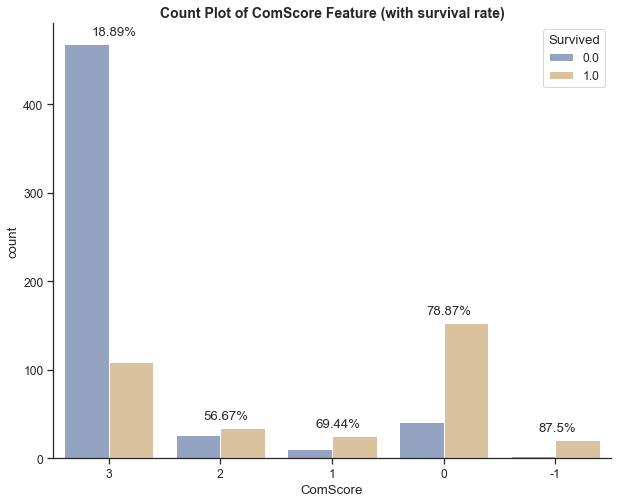

In [43]:
fig = plt.figure(figsize=(10, 8))
palette = sns.color_palette('Set2')[2:7:4]
ax = sns.countplot(data=data, x='ComScore', order=[3,2,1,0,-1], hue='Survived', palette=palette)

# annotate with survival rate
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right, rate in zip(left_bars, right_bars, survival_rate):
  height_l = left.get_height()
  height_r = right.get_height()
  total = height_l + height_r

  ax.text(left.get_x() + 0.25, max(height_l, height_r) + 10, rate)
  # ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
  # ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
plt.title('Count Plot of ComScore Feature (with survival rate)', fontdict = {'fontsize' : 14, 'fontweight':'heavy'})
sns.despine();

This new feature `ComScore` captures the trend we saw more or less. You can see that the survival rate for a score of 3 is the lowest and it increases as the score reaches -1.


In [44]:
# Family size binning
data.loc[data['FamilySize'] == 1, 'FamilySize'] = 1                                # Alone
data.loc[(data['FamilySize'] >= 2) & (data['FamilySize'] <= 4), 'FamilySize'] = 0  # Small Family 
data.loc[(data['FamilySize'] >= 5) & (data['FamilySize'] <= 6), 'FamilySize'] = 2  # Medium Family
data.loc[data['FamilySize']  >= 7, 'FamilySize'] = 3                               # Large Family 

In [45]:
# keeps only ticket number and assign random to LINE
data.Ticket = data.Ticket.replace("LINE","244")
data['Ticket'] = data.Ticket.str.split().apply(lambda x : x[:][-1])
data.Ticket = data.Ticket.values.astype('int64')

### New Numerical Feature: WCrate (the survival rate of women and child in each family(same ticket number))

In [46]:
data['FemChi'] = ((data['Age'] == 0) | (data['Sex'] == 0))
family = data.groupby([data.Ticket]).Survived

data['WCcount'] = family.transform(lambda s: s[data.FemChi].fillna(0).count())# count how many female and childs in each family
data['WCcount'] = data.mask(data.FemChi, data['WCcount'] , axis=0)

data['WCsurvived'] = family.transform(lambda s: s[data.FemChi].sum())# sum how many female and childs survived in each family
data['WCsurvived'] = data.mask(data.FemChi, data.WCsurvived - data.Survived.fillna(0), axis=0)

# compute the survival rate of female and childs in each family
data['WCrate'] = (data.WCsurvived / data.WCcount.replace(0, np.nan))
data['WCrate'].fillna(0, inplace = True)

For this feature, please refer to [this notebook](https://www.kaggle.com/javiervallejos/titanic-simple-decision-tree-model-score-top-3?scriptVersionId=74284968) for more detail.

## One Hot Encoding and Scaling

In [47]:
# drop unused variables
data.drop(['WCcount','WCsurvived','FemChi','SibSp','Parch'], axis = 1, inplace = True)

In [48]:
data.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,FamilySize,ComScore,WCrate
PassengerId,,,,,,,,,
1,0.0,3,1,1,21171,0,0,3,0.0
2,1.0,1,0,2,17599,0,0,0,0.0
3,1.0,3,0,1,3101282,0,1,0,0.0
4,1.0,1,0,2,113803,0,0,0,0.0
5,0.0,3,1,2,373450,0,1,3,0.0


In [49]:
# onehot encoding
# for Sex we think retaining more redundancy can help prediction in deeper layers
# for low relevance features('Pclass','Fare','Pclass') use onehot encoding 
# for high relevance features('Parch'), use integer to preserve encoded preference
# for "Ticket" with many discrete values, we use min_smaple_split in DecisionTree to prevent overfitting
data = pd.get_dummies(data, columns=['Sex','Pclass','Fare'])
data.head()

,Survived,Age,Ticket,FamilySize,ComScore,WCrate,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Fare_0,Fare_1,Fare_2,Fare_3
PassengerId,,,,,,,,,,,,,,,
1,0.0,1,21171,0,3,0.0,0,1,0,0,1,1,0,0,0
2,1.0,2,17599,0,0,0.0,1,0,1,0,0,1,0,0,0
3,1.0,1,3101282,1,0,0.0,1,0,0,0,1,1,0,0,0
4,1.0,2,113803,0,0,0.0,1,0,1,0,0,1,0,0,0
5,0.0,2,373450,1,3,0.0,0,1,0,0,1,1,0,0,0


In [50]:
# indexing train and test by Passenger id
data['PassengerId'] = data.index
train, test = data.loc[train.index], data.loc[test.index]
X_train = train.drop(['Survived','PassengerId'], axis = 1)
col_names = X_train.columns
y_train = train["Survived"]

X_test = test.drop(['Survived','PassengerId'], axis = 1)

In [51]:
# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Modeling

In [52]:
# min_samples_split==2 will leads to acc==1.0 (total fit), so we inscrease it to 3 [though this is still quite a overfit]
decision_tree = DecisionTreeClassifier(min_samples_split=3)
decision_tree.fit(X_train, y_train)
print("train_acc",decision_tree.score(X_train, y_train))

train_acc 0.9943883277216611


In [53]:
cv_score = cross_val_score(decision_tree, X_train, y_train, cv=5)
print(cv_score)
print('model accuracy of decision tree validated by cv=5 is', cv_score.mean())

[0.88268156 0.89325843 0.91573034 0.92696629 0.92134831]
model accuracy of decision tree validated by cv=5 is 0.9079969870064655


## Feature Importance

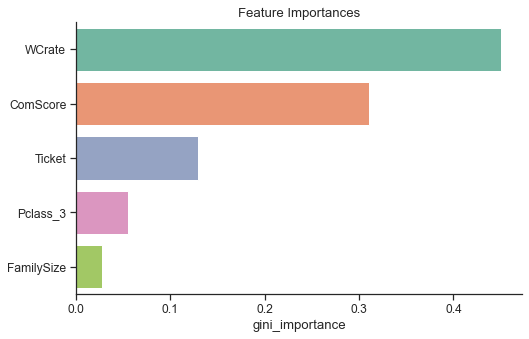

In [54]:
importances = pd.DataFrame({'gini_importance':decision_tree.feature_importances_}, index = col_names)
importances.sort_values('gini_importance', inplace=True, ascending=False)
importances = importances.iloc[0:5,:]

plt.figure(figsize=(8, 5)) 
sns.barplot(x=importances.gini_importance, y=importances.index, data=importances,palette="Set2").set_title("Feature Importances");
sns.despine()

In [55]:
test_pred = decision_tree.predict(X_test)
answer = pd.DataFrame({"PassengerId":test.PassengerId, 
                        'Survived':test_pred.astype(int)})
answer.reset_index(drop=True, inplace=True)
# answer.to_csv("244_submission.csv",index = False)

In [56]:
answer.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
